# Simple RNN implementation

In [13]:
!pip install -q gensim torch pandas matplotlib scikit-learn wordcloud kagglehub

In [3]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device}")

Running on cpu


## Explore dataset

In [5]:
import pandas as pd

df = pd.read_csv("amazon_reviews.csv")
df = df.dropna()

In [6]:
df.head(5)

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0


In [7]:
df.describe()

,cleaned_review_length,review_score
count,17337.000000,17337.000000
mean,30.305705,3.648901
std,35.837424,1.673580
min,0.000000,1.000000
25%,9.000000,2.000000
50%,20.000000,5.000000
75%,38.000000,5.000000
max,571.000000,5.000000


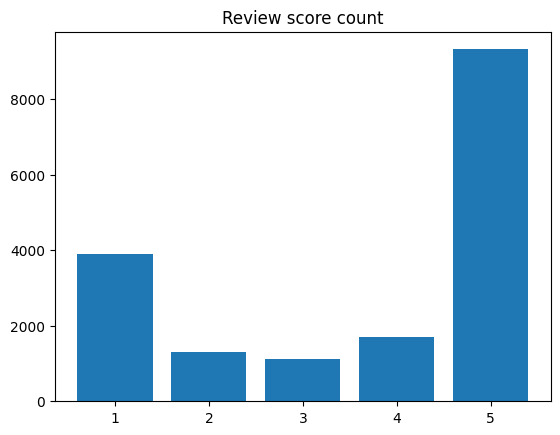

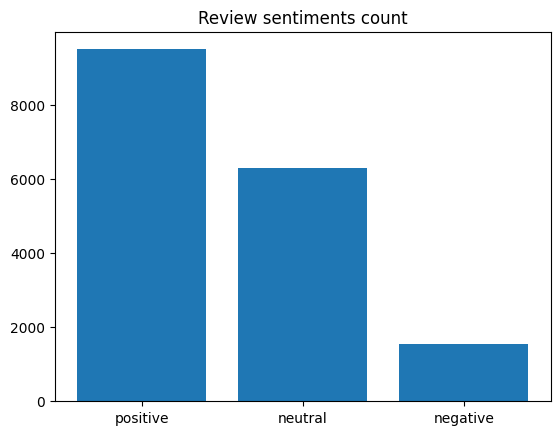

In [8]:
import matplotlib.pyplot as plt

scores = df.review_score.value_counts().to_dict()
plt.title("Review score count")
plt.bar(
    [k for k in scores.keys()],
    [v for v in scores.values()],
    label="Number of reviews",
    align="center",
)
plt.show()

sentiments = df.sentiments.value_counts().to_dict()
plt.title("Review sentiments count")
plt.bar(
    [k for k in sentiments.keys()],
    [v for v in sentiments.values()],
    label="Number of reviews",
    align="center",
)
plt.show()

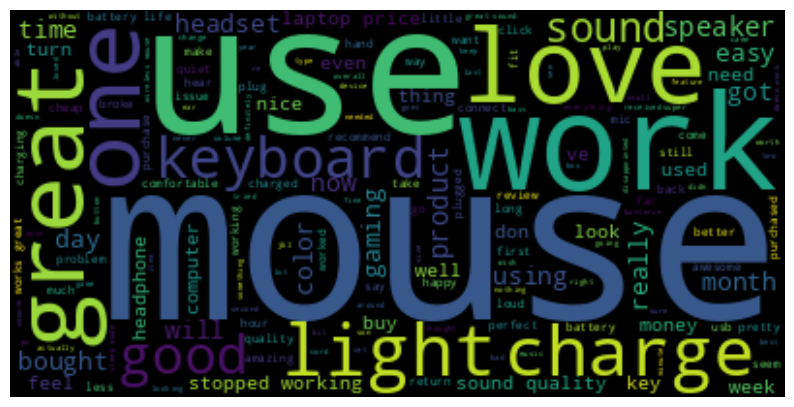

In [9]:
from wordcloud import WordCloud

combined_reviews = "".join([rev for rev in df.cleaned_review.values])
text = df.cleaned_review[0]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(combined_reviews)

# Display the generated image:
plt.figure(figsize=[10, 7])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Prepare dataset for _review_score_ prediction

The task of the exercise will be to predict _review score_ basing on comments.
This step drops unused columns _sentiments_ and _cleaned_review_length_ as the lengths will be calculated to ensure correct values. Dataset will be balanced as number of extremly positive and extremy negative feedback are overrepresented.

In [10]:
df = df.drop(columns=["sentiments", "cleaned_review_length"])

df.review_score = df.review_score.convert_dtypes(convert_integer=True)

# take 1000 for each score for balanced data (otherwise more frequent scores will be prefered)
n = 1000
one = df[df.review_score == 1].sample(n, random_state=42)
two = df[df.review_score == 2].sample(n, random_state=42)
three = df[df.review_score == 3].sample(n, random_state=42)
four = df[df.review_score == 4].sample(n, random_state=42)
five = df[df.review_score == 5].sample(n, random_state=42)

df = pd.concat([one, two, three, four, five], axis=0)

df.review_score = df.review_score.values - 1  # make classes 0-4 for cross entrophy
df.review_score.value_counts()

review_score
0    1000
1    1000
2    1000
3    1000
4    1000
Name: count, dtype: Int64

In [11]:
df["review_tokens"] = [
    str(review).strip().split(sep=" ") for review in df.cleaned_review
]
df

,cleaned_review,review_score,review_tokens
14588,used it indoors and outdoors,0,"[used, it, indoors, and, outdoors]"
2327,this product is excellent love its lights it c...,0,"[this, product, is, excellent, love, its, ligh..."
847,ok like to recommend that you really think abo...,0,"[ok, like, to, recommend, that, you, really, t..."
6090,the mouse works fine it is slim kind of cheap ...,0,"[the, mouse, works, fine, it, is, slim, kind, ..."
4445,i would buy it against it pretty not really bl...,0,"[i, would, buy, it, against, it, pretty, not, ..."
...,...,...,...
14970,i bought this about months ago and it worked p...,4,"[i, bought, this, about, months, ago, and, it,..."
7515,this product works great,4,"[this, product, works, great]"
12550,i love theme for everything,4,"[i, love, theme, for, everything]"
15149,its not too heavy it produces great sound the ...,4,"[its, not, too, heavy, it, produces, great, so..."


### Word embedings

To embed words pretrained Word2Vec model will be used. The model was trained on Google News dataset.

In [14]:
import kagglehub

path = kagglehub.dataset_download("leadbest/googlenewsvectorsnegative300")

print("Path to dataset files:", path)

/home/marcin/projects/WSEI-NLP/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 3.17G/3.17G [01:38<00:00, 34.6MB/s] 

Extracting files...


Path to dataset files: /home/marcin/.cache/kagglehub/datasets/leadbest/googlenewsvectorsnegative300/versions/2


In [15]:
full_path = path + "/GoogleNews-vectors-negative300.bin"

In [16]:
import gensim

w2v = gensim.models.KeyedVectors.load_word2vec_format(full_path, binary=True)

# Create a vocab
all_tokens = set(token for tokens in df.review_tokens for token in tokens)
word2idx = {
    word: i + 1 for i, word in enumerate(all_tokens)
}  # reserve 0 for padding/unknown

vocab_size = len(word2idx) + 1
embed_dim = w2v.vector_size
embedding_matrix = torch.zeros(vocab_size, embed_dim)

# Build embedding matrix using pretrained vectors
for word, idx in word2idx.items():
    if word in w2v:
        embedding_matrix[idx] = torch.tensor(w2v[word])
    else:
        embedding_matrix[idx] = torch.zeros(embed_dim)


def tokens_to_ids(tokens):
    return [word2idx.get(token, 0) for token in tokens]  # 0 = unknown/pad


df["review_embeding_ids"] = df.review_tokens.apply(tokens_to_ids)

In [17]:
df["review_embeding_ids"].head(3)

14588                          [761, 4686, 921, 3154, 543]
2327     [88, 3976, 864, 1042, 4307, 4644, 2716, 4686, ...
847      [5656, 2664, 1145, 345, 1585, 1074, 5523, 5615...
Name: review_embeding_ids, dtype: object

In [18]:
w2v.most_similar("mouse")

[('Logitech_MX_Revolution', 0.6175230741500854),
 ('Razer_Mamba', 0.5994570851325989),
 ('mice', 0.5896884799003601),
 ('cordless_laser', 0.5652030110359192),
 ('VX_Nano', 0.5619357824325562),
 ('Logitech_MX###', 0.5604779124259949),
 ('keyboard_arrow_keys', 0.5545550584793091),
 ('Logitech_G9x', 0.5538491606712341),
 ('NOTE_TO_READERS_Hovering', 0.5520266890525818),
 ('Razer_Abyssus', 0.5489388108253479)]

### Apply padding to ensure same sequence lengths

The following sequence will apply padding to the review sentenses. Padding is used to create proper matrix dataset.

In [25]:
import torch
import torch.nn as nn

review_tensors = [torch.tensor(rev) for rev in df.review_embeding_ids]
padded = nn.utils.rnn.pad_sequence(review_tensors, batch_first=True, padding_value=0)
padded

tensor([[2738, 2809, 1131,  ...,    0,    0,    0],
        [2450,  376, 5101,  ...,    0,    0,    0],
        [3024, 4107, 3829,  ...,    0,    0,    0],
        ...,
        [3418, 2870,   63,  ...,    0,    0,    0],
        [4502, 5713, 4667,  ...,    0,    0,    0],
        [2152, 4400,  761,  ...,    0,    0,    0]])

In [41]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

X = padded.int()
print(f"X size {X.size()}")
y = torch.tensor(df.review_score.values).long()
print(f"y size {y.size()}")
lengths = torch.tensor([len(seq) for seq in df["review_embeding_ids"]])

# split 80/20
X_train, X_test, y_train, y_test, lengths_train, lengths_test = train_test_split(
    X, y, lengths, test_size=0.2, random_state=42, stratify=y
)

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

train_ds = TensorDataset(X_train, y_train, lengths_train)
test_ds = TensorDataset(X_test, y_test, lengths_test)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

X size torch.Size([5000, 460])
y size torch.Size([5000])


## Models definitions

Five models are implenented: SimpleRNN, LSTM, GRU and bidirectional versions of LSTM and GRU. The embeding matrix is passed as an argument with sentense lengts to properly use embedings and remove padding.

In [42]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence


class RNN(nn.Module):
    def __init__(
        self,
        embedding_matrix,
        hidden_dim,
        num_classes,
        freeze=False,
        dropout=0,
        layers=1,
    ):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix, freeze=freeze, padding_idx=0
        )
        self.rnn = nn.RNN(
            embedding_matrix.size(1),
            hidden_dim,
            num_layers=layers,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, h_n = self.rnn(packed)
        return self.fc(h_n[-1])


class LSTM(nn.Module):
    def __init__(
        self,
        embedding_matrix,
        hidden_dim,
        num_classes,
        freeze=False,
        dropout=0,
        layers=1,
    ):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix, freeze=freeze, padding_idx=0
        )
        self.lstm = nn.LSTM(
            embedding_matrix.size(1),
            hidden_dim,
            num_layers=layers,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (h_n, _) = self.lstm(packed)
        return self.fc(h_n[-1])


class BiLSTM(nn.Module):
    def __init__(
        self,
        embedding_matrix,
        hidden_dim,
        num_classes,
        freeze=False,
        dropout=0,
        layers=1,
    ):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix, freeze=freeze, padding_idx=0
        )
        self.lstm = nn.LSTM(
            embedding_matrix.size(1),
            hidden_dim,
            batch_first=True,
            num_layers=layers,
            bidirectional=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (h_n, _) = self.lstm(packed)
        h_cat = torch.cat((h_n[-2], h_n[-1]), dim=1)
        return self.fc(h_cat)


class GRU(nn.Module):
    def __init__(
        self,
        embedding_matrix,
        hidden_dim,
        num_classes,
        freeze=False,
        dropout=0,
        layers=1,
    ):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix, freeze=freeze, padding_idx=0
        )
        self.gru = nn.GRU(
            embedding_matrix.size(1),
            hidden_dim,
            batch_first=True,
            num_layers=layers,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, h_n = self.gru(packed)
        return self.fc(h_n[-1])


class BiGRU(nn.Module):
    def __init__(
        self,
        embedding_matrix,
        hidden_dim,
        num_classes,
        freeze=False,
        dropout=0,
        layers=1,
    ):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix, freeze=freeze, padding_idx=0
        )
        self.gru = nn.GRU(
            embedding_matrix.size(1),
            hidden_dim,
            batch_first=True,
            num_layers=layers,
            bidirectional=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, h_n = self.gru(packed)
        h_cat = torch.cat((h_n[-2], h_n[-1]), dim=1)
        return self.fc(h_cat)

## Learing/evaluating loop

The traing includes early stopping based on accuracy. The criterium for loss calculation is Cross Entropy

Model: RNN (32 hidden, 1 layers)
  Epoch [1\21]
  Epoch [2\21]
  Epoch [3\21]
  Epoch [4\21]
  Epoch [5\21]
  Epoch [6\21]
  Epoch [7\21]
Early stop, patience extended


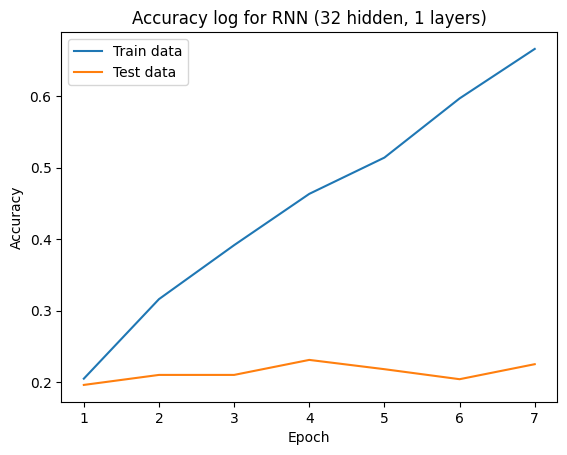

Model: RNN (32 hidden, 2 layers)
  Epoch [1\21]
  Epoch [2\21]
  Epoch [3\21]
  Epoch [4\21]
  Epoch [5\21]
  Epoch [6\21]
  Epoch [7\21]
Early stop, patience extended


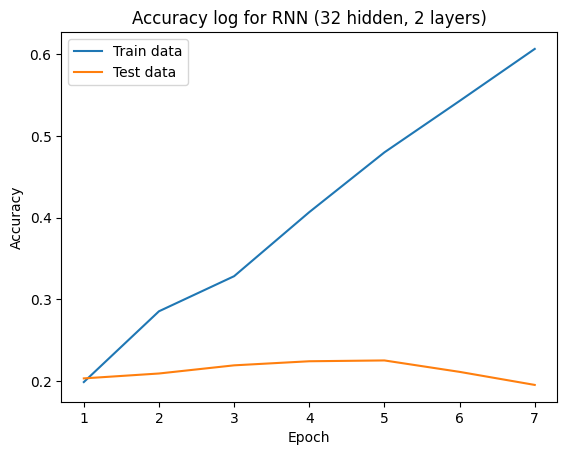

Model: LSTM (32 hidden, 1 layers)
  Epoch [1\21]
  Epoch [2\21]
  Epoch [3\21]
  Epoch [4\21]
  Epoch [5\21]
  Epoch [6\21]
  Epoch [7\21]
Early stop, patience extended


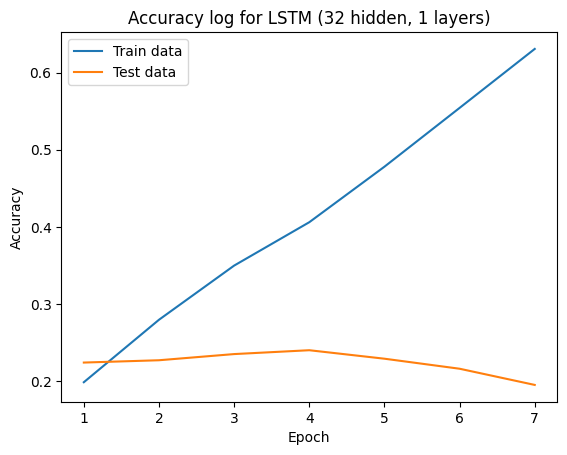

Model: LSTM (32 hidden, 2 layers)
  Epoch [1\21]
  Epoch [2\21]
  Epoch [3\21]
  Epoch [4\21]
  Epoch [5\21]
  Epoch [6\21]
  Epoch [7\21]
Early stop, patience extended


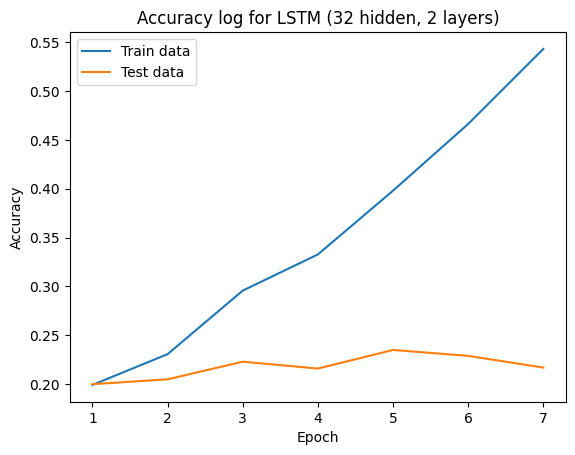

Model: GRU (32 hidden, 1 layers)
  Epoch [1\21]
  Epoch [2\21]
  Epoch [3\21]
  Epoch [4\21]
  Epoch [5\21]
  Epoch [6\21]
  Epoch [7\21]
Early stop, patience extended


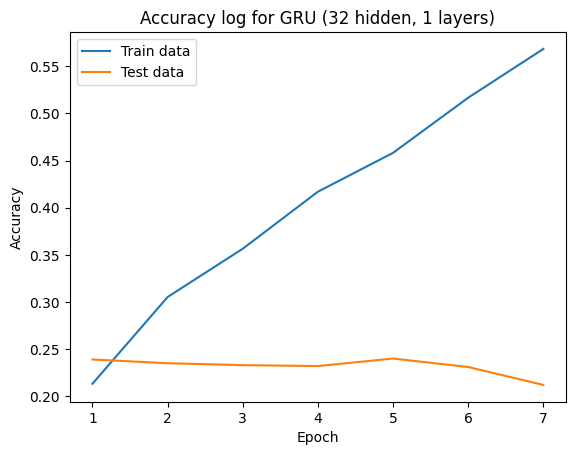

Model: GRU (32 hidden, 2 layers)
  Epoch [1\21]
  Epoch [2\21]
  Epoch [3\21]
  Epoch [4\21]
  Epoch [5\21]
  Epoch [6\21]
  Epoch [7\21]
Early stop, patience extended


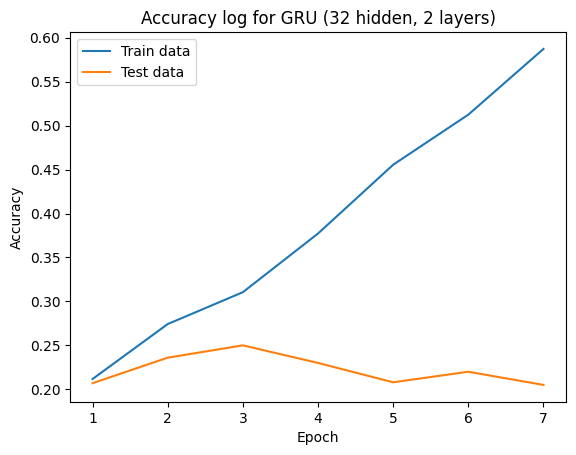

Model: BiGRU (32 hidden, 1 layers)
  Epoch [1\21]
  Epoch [2\21]
  Epoch [3\21]
  Epoch [4\21]
  Epoch [5\21]
  Epoch [6\21]
  Epoch [7\21]
Early stop, patience extended


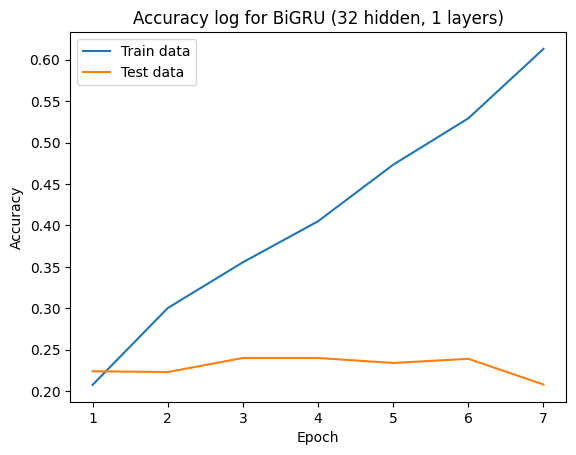

Model: BiGRU (32 hidden, 2 layers)
  Epoch [1\21]
  Epoch [2\21]
  Epoch [3\21]
  Epoch [4\21]
  Epoch [5\21]
  Epoch [6\21]
  Epoch [7\21]
Early stop, patience extended


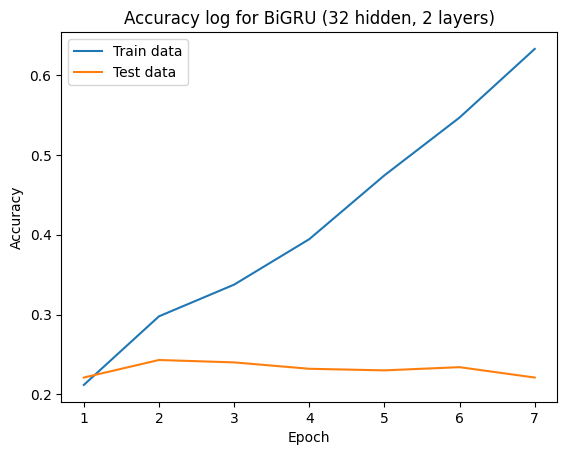

Model: BiLSTM (32 hidden, 1 layers)
  Epoch [1\21]
  Epoch [2\21]
  Epoch [3\21]
  Epoch [4\21]
  Epoch [5\21]
  Epoch [6\21]
  Epoch [7\21]
Early stop, patience extended


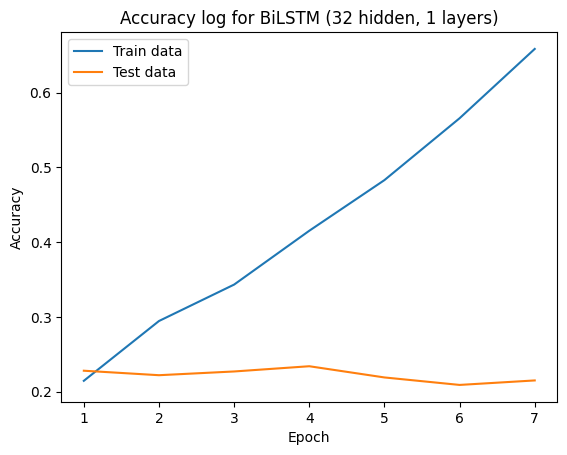

Model: BiLSTM (32 hidden, 2 layers)
  Epoch [1\21]
  Epoch [2\21]
  Epoch [3\21]
  Epoch [4\21]
  Epoch [5\21]
  Epoch [6\21]
  Epoch [7\21]
Early stop, patience extended


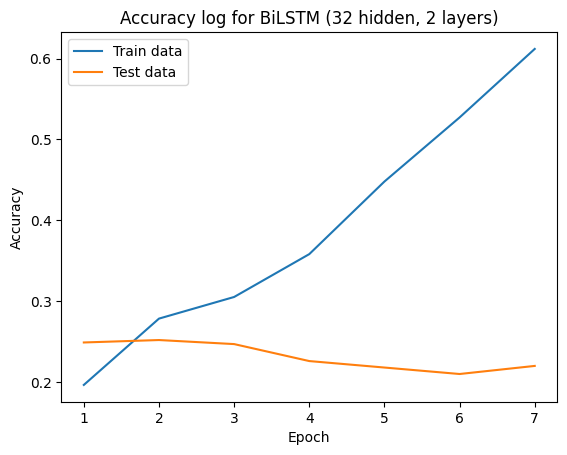

In [52]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

vocab_size = len(word2idx) + 1
embedding_dim = 100
num_classes = 5  # number of classes
dropout = 0.3

models = {
    "RNN (32 hidden, 1 layers)": RNN(
        embedding_matrix=embedding_matrix,
        hidden_dim=32,
        layers=1,
        num_classes=num_classes,
    ).to(device),
    "RNN (32 hidden, 2 layers)": RNN(
        embedding_matrix=embedding_matrix,
        hidden_dim=32,
        layers=2,
        num_classes=num_classes,
        dropout=dropout,
    ).to(device),
    "LSTM (32 hidden, 1 layers)": LSTM(
        embedding_matrix=embedding_matrix,
        hidden_dim=32,
        layers=1,
        num_classes=num_classes,
    ).to(device),
    "LSTM (32 hidden, 2 layers)": LSTM(
        embedding_matrix=embedding_matrix,
        hidden_dim=32,
        layers=2,
        num_classes=num_classes,
        dropout=dropout,
    ).to(device),
    "GRU (32 hidden, 1 layers)": GRU(
        embedding_matrix=embedding_matrix,
        hidden_dim=32,
        layers=1,
        num_classes=num_classes,
    ).to(device),
    "GRU (32 hidden, 2 layers)": GRU(
        embedding_matrix=embedding_matrix,
        hidden_dim=32,
        layers=2,
        num_classes=num_classes,
        dropout=dropout,
    ).to(device),
    "BiGRU (32 hidden, 1 layers)": BiGRU(
        embedding_matrix=embedding_matrix,
        hidden_dim=32,
        layers=1,
        num_classes=num_classes,
    ).to(device),
    "BiGRU (32 hidden, 2 layers)": BiGRU(
        embedding_matrix=embedding_matrix,
        hidden_dim=32,
        layers=2,
        num_classes=num_classes,
        dropout=dropout,
    ).to(device),
    "BiLSTM (32 hidden, 1 layers)": BiLSTM(
        embedding_matrix=embedding_matrix,
        hidden_dim=32,
        layers=1,
        num_classes=num_classes,
    ).to(device),
    "BiLSTM (32 hidden, 2 layers)": BiLSTM(
        embedding_matrix=embedding_matrix,
        hidden_dim=32,
        layers=2,
        num_classes=num_classes,
        dropout=dropout,
    ).to(device),
}


epochs = 21
base_patience = 5  # for early stoping

for name, model in models.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_acc = []
    test_acc = []
    best_test_acc = -1
    patience = base_patience

    print(f"Model: {name}")
    for e in range(epochs):
        # TRAIN
        model.train()
        train_preds = []
        train_targets = []
        train_loss = 0

        for X_batch, y_batch, lengths in train_loader:
            y_pred = model(X_batch, lengths)
            loss = criterion(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            preds = torch.argmax(y_pred, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(y_batch.cpu().numpy())

        epoch_train_acc = accuracy_score(train_targets, train_preds)
        train_acc.append(epoch_train_acc)

        # TEST
        model.eval()
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for X_batch, y_batch, lengths in test_loader:
                y_pred = model(X_batch, lengths)
                preds = torch.argmax(y_pred, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(y_batch.cpu().numpy())

        epoch_test_acc = accuracy_score(val_targets, val_preds)
        test_acc.append(epoch_test_acc)
        # LOGGING
        print(f"  Epoch [{e+1}\{epochs}]")
        # print(f"    Train Acc: {epoch_train_acc}")
        # print(f"    Test Acc: {epoch_test_acc}")

        # Early stopping
        if epoch_test_acc < best_test_acc + 0.1:
            patience -= 1
        else:
            patience = base_patience

        if patience < 0:
            print("Early stop, patience extended")
            break

        best_test_acc = max(best_test_acc, epoch_test_acc)

    plt.title(f"Accuracy log for {name}")
    plt.plot(np.arange(1, len(train_acc) + 1), train_acc, label="Train data")
    plt.plot(np.arange(1, len(test_acc) + 1), test_acc, label="Test data")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

## Results
### VERSION 1
The first version had multiple issues - the embedings were not properly passed to models and embedings themself were trained on the corpus extracted from the dataset. Even though there was a padding applied, models were not skipping padded values while training.

### VERSION 2
Second version handles embedings properly. Lenghts were added to DataLoader to skip padding. Pretrained embeding model was added to catch semantic relations better. Currently all models are overfitting and accuracy for test data is about 20% which means totally random results.

## Final thoughts:
There can be multiple issues explaining why models are not generalizing properly and the accuracy on never-seen data is the same as if scores were predicted randmly. That behaviourmay be caused by implementation issues, wrong architecture or some bug. Maybe the dataset is too small to extract general patterns from it.